In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import akshare as ak
import datetime
from datetime import date, timedelta
import seaborn as sns
import time
import random
import itertools
import decimal

from fund_tools import *
from AIP import *

In [2]:
# Set date variable

today = date.today()
first_day_of_the_week = today - timedelta(days=today.weekday())
# end = start + timedelta(days=6)
print("Today: " + str(today))
print("Start: " + str(first_day_of_the_week))
# print("End: " + str(end))

Today: 2021-10-04
Start: 2021-10-04


### Examples for using methods in AIP and fund_tools

In [3]:
start_date = '2015-01-01'
end_date = '2021-09-30'

fund_net_value = get_fund_net_worth('001980',start_date=start_date, end_date=end_date, fund_category='open')
fund_net_value

,净值日期,单位净值,日增长率
0,2018-05-16,1.0000,0.00
1,2018-05-18,1.0002,0.00
2,2018-05-25,1.0003,0.00
3,2018-06-01,0.9999,0.00
4,2018-06-08,1.0008,0.00
...,...,...,...
807,2021-09-24,1.9603,-1.39
808,2021-09-27,1.9263,-1.73
809,2021-09-28,1.9249,-0.07
810,2021-09-29,1.8725,-2.72


In [4]:
AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171


In [5]:
AIP_direct_df = AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', AIP=False, df=False)
AIP_direct_df

,基金代码,持有天数,总购买份额,累计收益,累计收益率,年化收益率
DIP,001980,1234,100000.000,91090.000,0.911,0.211


In [6]:
AIP_df = AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', AIP=True, df=True)
AIP_df

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数(定投),年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
1,2018-05-18,1.0002,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
2,2018-05-25,1.0003,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
3,2018-06-01,0.9999,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
4,2018-06-08,1.0008,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,157000,0.000000,137947.604561,1.138113,113418.689220,1188,0.181818,0.722412
808,2021-09-27,1.9263,-1.73,Monday,1000,158000,519.129938,138466.734499,1.141068,108728.470665,1191,0.174070,0.688155
809,2021-09-28,1.9249,-0.07,Tuesday,0,158000,0.000000,138466.734499,1.141068,108534.617237,1192,0.173651,0.686928
810,2021-09-29,1.8725,-2.72,Wednesday,0,158000,0.000000,138466.734499,1.141068,101278.960349,1193,0.163626,0.641006


In [7]:
Freq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '001980', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171
AIP,001980,1200,Tuesday,1000,162.0,141338.483,1.146,108083.707,0.667,0.168
AIP,001980,1234,Wednesday,1000,164.0,143250.605,1.145,109737.582,0.669,0.164
AIP,001980,1205,Thursday,1000,164.0,143136.130,1.146,109518.831,0.668,0.168
AIP,001980,1232,Friday,1000,162.0,141864.343,1.142,109088.573,0.673,0.165


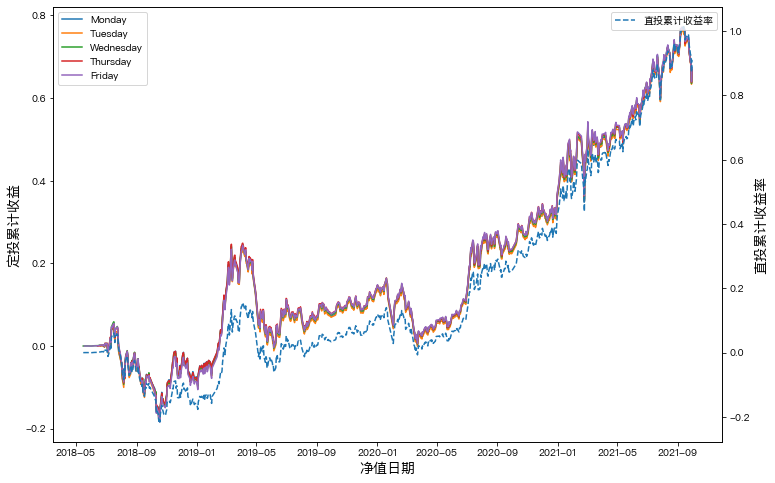

In [8]:
AIP_Weekly_plot('001980', start_date, end_date, 'open')

In [9]:
Max_AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1089,-3.0,2.0,1000,12,11,1368.136,0.731,1614.371,1.614,0.380


In [10]:
Max_AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, AIP=False, df=False)

,基金代码,持有天数,总购买份额,累计收益,累计收益率,年化收益率
DIP,001980,1234,100000.000,91090.000,0.911,0.211


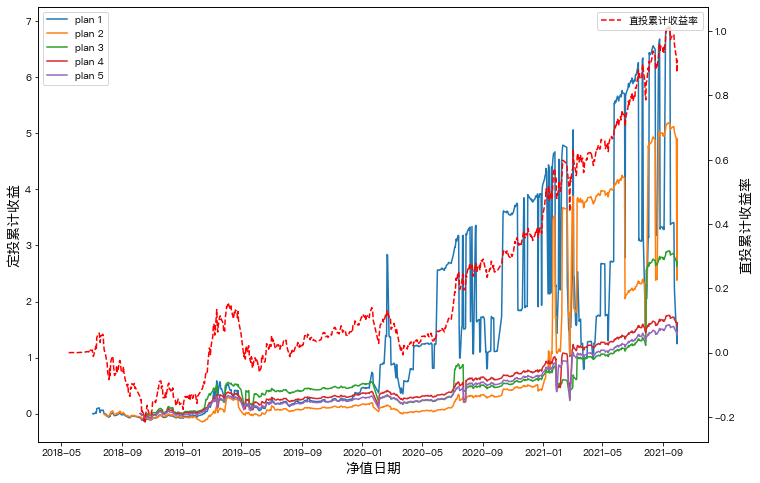

In [11]:
Max_AIP_Weekly_plot('001980', start_date, end_date, 'open')

In [12]:
df = Max_AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, df=True)
df

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数,年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
1,2018-05-18,1.0002,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
2,2018-05-25,1.0003,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
3,2018-06-01,0.9999,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
4,2018-06-08,1.0008,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,1000,0.0,1368.136167,0.730921,1681.957327,1083,0.394440,1.681957
808,2021-09-27,1.9263,-1.73,Monday,0,1000,0.0,1368.136167,0.730921,1635.440698,1086,0.384991,1.635441
809,2021-09-28,1.9249,-0.07,Tuesday,0,1000,0.0,1368.136167,0.730921,1633.525307,1087,0.384238,1.633525
810,2021-09-29,1.8725,-2.72,Wednesday,0,1000,0.0,1368.136167,0.730921,1561.834972,1088,0.371071,1.561835


In [13]:
upper_threshold = [1.0, 2.0, 3.0, 4.0, 5.0]
lower_threshold = [-1.0, -2.0, -3.0, -4.0, -5.0]

Max_AIP_Weekly_Plans('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, 
                     upper_threshold=upper_threshold, lower_threshold=lower_threshold)

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1185,-1.0,1.0,1000,130,126,5472.049,0.731,6456.538,1.614,0.344
Plan,001980,1185,-1.0,2.0,1000,130,51,73530.342,1.074,61509.130,0.779,0.194
Plan,001980,1185,-1.0,3.0,1000,130,20,100104.242,1.099,81289.196,0.739,0.186
Plan,001980,1185,-1.0,4.0,1000,130,4,115089.750,1.095,93925.003,0.745,0.187
Plan,001980,1185,-1.0,5.0,1000,130,2,117055.368,1.093,95681.102,0.748,0.188
Plan,001980,1163,-2.0,1.0,1000,43,42,1250.628,0.800,1389.825,1.390,0.314
Plan,001980,1163,-2.0,2.0,1000,43,42,3086.672,0.324,4898.321,4.898,0.745
Plan,001980,1163,-2.0,3.0,1000,43,19,22250.803,1.079,18519.060,0.772,0.197
Plan,001980,1163,-2.0,4.0,1000,43,4,36281.475,1.075,30330.270,0.778,0.198
Plan,001980,1163,-2.0,5.0,1000,43,2,38247.093,1.072,32086.370,0.783,0.199


In [14]:
StochasticAIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, Freq=5, seed=12345, df=True)

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数,年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
1,2018-05-18,1.0002,0.00,Friday,1000,1000,999.800040,999.800040,1.000200,0.000000,1,0.000000,0.000000
2,2018-05-25,1.0003,0.00,Friday,1000,2000,999.700090,1999.500130,1.000250,0.099980,8,0.002283,0.000050
3,2018-06-01,0.9999,0.00,Friday,1000,3000,1000.100010,2999.600140,1.000133,-0.699820,15,-0.005661,-0.000233
4,2018-06-08,1.0008,0.00,Friday,1000,4000,999.200639,3998.800779,1.000300,1.999820,22,0.008327,0.000500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,171000,0.000000,150467.618741,1.136457,123961.673018,1226,0.176224,0.724922
808,2021-09-27,1.9263,-1.73,Monday,0,171000,0.000000,150467.618741,1.136457,118845.773980,1229,0.169665,0.695005
809,2021-09-28,1.9249,-0.07,Tuesday,0,171000,0.000000,150467.618741,1.136457,118635.119314,1230,0.169263,0.693773
810,2021-09-29,1.8725,-2.72,Wednesday,0,171000,0.000000,150467.618741,1.136457,110750.616092,1231,0.159586,0.647664


In [15]:
Freq = 5
seed = [1234, 123, 2133, 2314, 435]

StochasticAIP_Weekly_Plans(Freq=Freq, seed=seed, code='001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1232,随机,1000,171.0,150398.751,1.137,116396.973,0.681,0.166
Plan,001980,1232,随机,1000,170.0,150046.083,1.133,116723.059,0.687,0.167
Plan,001980,1232,随机,1000,170.0,149740.853,1.135,116139.797,0.683,0.167
Plan,001980,1232,随机,1000,172.0,151156.080,1.138,116844.153,0.679,0.166
Plan,001980,1232,随机,1000,172.0,151575.876,1.135,117646.342,0.684,0.167


In [16]:
Freq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '001980', start_date, end_date, fund_category='open', fixed_investment=1000, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171
AIP,001980,1200,Tuesday,1000,162.0,141338.483,1.146,108083.707,0.667,0.168
AIP,001980,1234,Wednesday,1000,164.0,143250.605,1.145,109737.582,0.669,0.164
AIP,001980,1205,Thursday,1000,164.0,143136.130,1.146,109518.831,0.668,0.168
AIP,001980,1232,Friday,1000,162.0,141864.343,1.142,109088.573,0.673,0.165


In [17]:
AIP_Weekly('004854', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,004854,1523,Monday,1000,196.0,218175.726,0.898,134143.509,0.684,0.133


In [18]:
Freq=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '004854', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,004854,1523,Monday,1000,196.0,218175.726,0.898,134143.509,0.684,0.133
AIP,004854,1487,Tuesday,1000,200.0,221677.315,0.902,135442.113,0.677,0.135
AIP,004854,1493,Wednesday,1000,203.0,224829.866,0.903,137212.553,0.676,0.135
AIP,004854,1492,Thursday,1000,202.0,224080.642,0.901,137078.828,0.679,0.135
AIP,004854,1519,Friday,1000,200.0,220934.707,0.905,134318.398,0.672,0.131


In [30]:
Total_df = current_open_fund_mergered()

In [20]:
AIP_Weekly('011146', start_date, end_date, 'open', fixed_investment=1000, freq='Monday', df=False, AIP=False)

,基金代码,持有天数,总购买份额,累计收益,累计收益率,年化收益率
DIP,011146,275,100000.000,59820.000,0.598,0.863


In [21]:
Freq=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '011146', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,011146,270,Monday,1000,34.0,28684.387,1.185,11843.387,0.348,0.498
AIP,011146,269,Tuesday,1000,36.0,30653.264,1.174,12990.046,0.361,0.519
AIP,011146,275,Wednesday,1000,38.0,32120.753,1.183,13335.387,0.351,0.491
AIP,011146,274,Thursday,1000,39.0,32988.098,1.182,13721.579,0.352,0.494
AIP,011146,266,Friday,1000,37.0,31235.197,1.185,12920.092,0.349,0.508


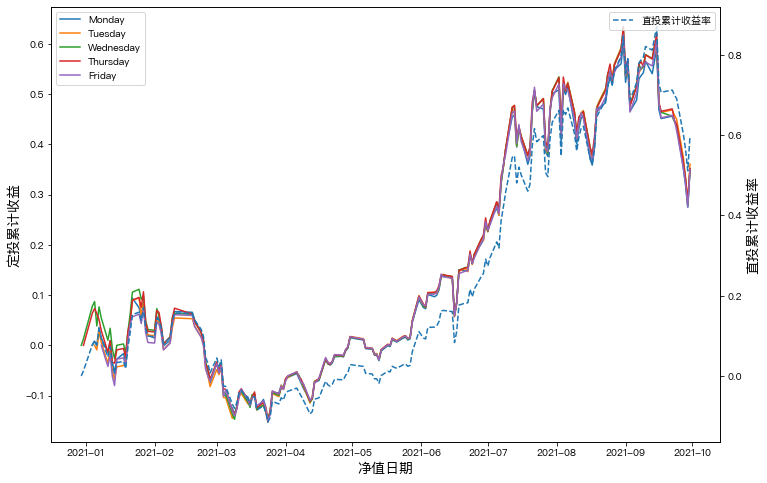

In [22]:
AIP_Weekly_plot('011146', start_date, end_date, 'open')

In [23]:
df = Max_AIP_Weekly('011146', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, df=False)
df 

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,011146,263,-3.0,2.0,1000,20,17,2528.494,1.186,1041.040,0.347,0.512


In [24]:
upper_threshold = [1.0, 2.0, 3.0, 4.0, 5.0]
lower_threshold = [-1.0, -2.0, -3.0, -4.0, -5.0]

Max_AIP_Weekly_Plans('011146', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, 
                     upper_threshold=upper_threshold, lower_threshold=lower_threshold)

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,011146,266,-1.0,1.0,1000,53,48,4409.093,1.134,2046.613,0.409,0.601
Plan,011146,266,-1.0,2.0,1000,53,44,11930.368,0.754,10067.115,1.119,1.801
Plan,011146,266,-1.0,3.0,1000,53,20,29372.756,1.123,13943.539,0.423,0.622
Plan,011146,266,-1.0,4.0,1000,53,14,34867.214,1.119,16724.782,0.429,0.632
Plan,011146,266,-1.0,5.0,1000,53,9,39590.381,1.111,19273.346,0.438,0.646
Plan,011146,266,-2.0,1.0,1000,29,25,2974.468,1.345,753.795,0.188,0.267
Plan,011146,266,-2.0,2.0,1000,29,25,3622.651,1.104,1789.721,0.447,0.661
Plan,011146,266,-2.0,3.0,1000,29,19,8198.891,1.220,3103.467,0.310,0.449
Plan,011146,266,-2.0,4.0,1000,29,14,12825.971,1.170,5498.466,0.367,0.535
Plan,011146,266,-2.0,5.0,1000,29,9,17549.137,1.140,8047.031,0.402,0.590


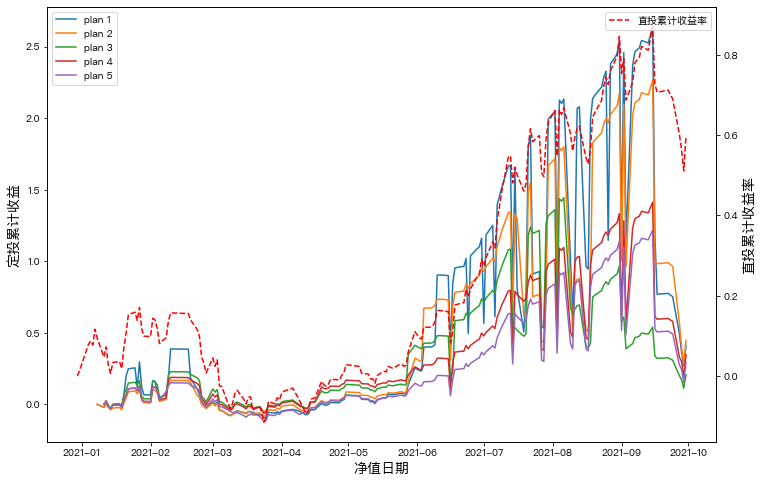

In [25]:
Max_AIP_Weekly_plot('011146', start_date, end_date, 'open')

In [26]:
StochasticAIP_Weekly('011146', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, Freq=5, seed=12345, df=True, AIP=True)

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数,年化收益率,累计收益率
0,2020-12-30,1.0000,0.00,Wednesday,1000,1000,1000.000000,1000.000000,1.000000,0.000000,1,0.000000,0.000000
1,2020-12-31,1.0130,1.30,Thursday,0,1000,0.000000,1000.000000,1.000000,13.000000,2,9.561456,0.013000
2,2021-01-04,1.0781,6.43,Monday,0,1000,0.000000,1000.000000,1.000000,78.100000,6,95.997074,0.078100
3,2021-01-05,1.0871,0.83,Tuesday,0,1000,0.000000,1000.000000,1.000000,87.100000,7,76.838621,0.087100
4,2021-01-06,1.0771,-0.92,Wednesday,1000,2000,928.418903,1928.418903,1.037119,77.100000,8,4.616950,0.038550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2021-09-24,1.6910,-0.56,Friday,1000,38000,591.366056,32125.163171,1.182873,16323.650923,269,0.624032,0.429570
180,2021-09-27,1.6034,-5.18,Monday,0,38000,0.000000,32125.163171,1.182873,13509.486629,272,0.504082,0.355513
181,2021-09-28,1.5645,-2.43,Tuesday,0,38000,0.000000,32125.163171,1.182873,12259.817782,273,0.453320,0.322627
182,2021-09-29,1.5113,-3.40,Wednesday,0,38000,0.000000,32125.163171,1.182873,10550.759101,274,0.385970,0.277652


In [27]:
Freq = 5
seed = [1234, 123, 2133, 2314, 435]

StochasticAIP_Weekly_Plans(Freq=Freq, seed=seed, code='011146', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,011146,274,随机,1000,38.0,32251.970,1.178,13545.099,0.356,0.501
Plan,011146,275,随机,1000,38.0,32068.172,1.185,13251.353,0.349,0.487
Plan,011146,275,随机,1000,39.0,33306.629,1.171,14230.655,0.365,0.511
Plan,011146,274,随机,1000,37.0,31168.708,1.187,12813.830,0.346,0.486
Plan,011146,269,随机,1000,37.0,31160.960,1.187,12801.446,0.346,0.497


In [28]:
Freq=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '011146', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,011146,270,Monday,1000,34.0,28684.387,1.185,11843.387,0.348,0.498
AIP,011146,269,Tuesday,1000,36.0,30653.264,1.174,12990.046,0.361,0.519
AIP,011146,275,Wednesday,1000,38.0,32120.753,1.183,13335.387,0.351,0.491
AIP,011146,274,Thursday,1000,39.0,32988.098,1.182,13721.579,0.352,0.494
AIP,011146,266,Friday,1000,37.0,31235.197,1.185,12920.092,0.349,0.508


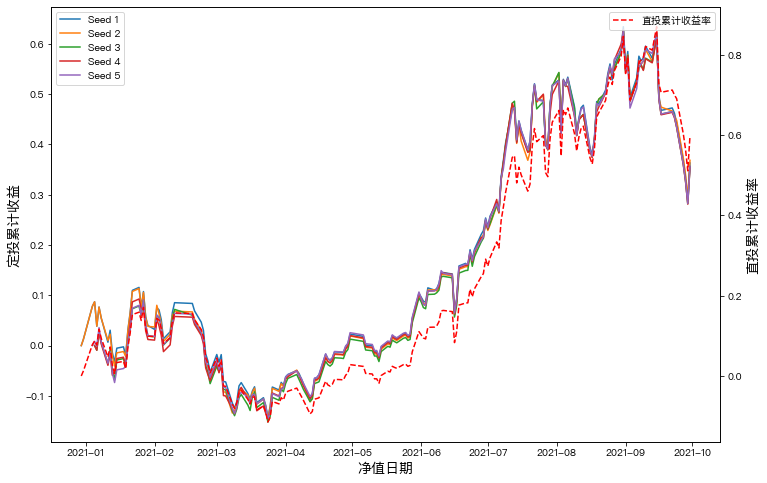

In [29]:
StochasticAIP_Weekly_plot('011146', start_date, end_date, 'open')

### Cross-sectional performance

In [5]:
all_cate_fund = get_category_all_funds()

In [6]:
GPX_fund_code = all_cate_fund['股票型']
QDII_fund_code = all_cate_fund['QDII']
ZQX_fund_code = all_cate_fund['债券型']
SPX_fund_code = all_cate_fund['商品（不含QDII）']
ZSX_fund_code = all_cate_fund['指数型']
HHX_fund_code = all_cate_fund['混合型']

In [7]:
def AIP_Weekly(code, start_date, end_date, fund_category, fixed_investment, freq='Monday', df=False, AIP=True, Total_investment=100000):


    fund_net_value = get_fund_net_worth(code, start_date=start_date, end_date=end_date, fund_category=fund_category)

    fund_net_value['WeekDay'] = pd.to_datetime(fund_net_value['净值日期']).dt.day_name()


    if AIP:
        fund_net_value['定投金额(本金)'] = 0.0

        for i in range(len(fund_net_value['WeekDay'])):
             if fund_net_value['WeekDay'].values[i] == freq:
                    fund_net_value['定投金额(本金)'][i] = fixed_investment

        fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
        fund_net_value['购买份额'] = fund_net_value['定投金额(本金)']/fund_net_value['单位净值']
        fund_net_value['累计份额'] = fund_net_value['购买份额'].cumsum()
        fund_net_value['平均成本'] = fund_net_value['累计定投金额(本金)']/fund_net_value['累计份额']

        fund_net_value['累计收益'] = (fund_net_value['单位净值'] - fund_net_value['平均成本']) * fund_net_value['累计份额']

        start_invest = fund_net_value['定投金额(本金)'].values.nonzero()[0][0]
        fund_net_value['持有天数(定投)'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][start_invest]).dt.days+1
        for i in range(len(fund_net_value['持有天数(定投)'])):
            if fund_net_value['持有天数(定投)'][i] < 0:
                fund_net_value['持有天数(定投)'][i] = 0
        fund_net_value['年化收益率'] = ((fund_net_value['累计收益'] + fund_net_value['累计定投金额(本金)'])/fund_net_value['累计定投金额(本金)'])**(365/fund_net_value['持有天数(定投)'])-1
        fund_net_value['累计收益率'] = fund_net_value['累计收益']/fund_net_value['累计定投金额(本金)']

        Stat_df = pd.DataFrame({
                '基金代码': code,
                '持有天数': fund_net_value['持有天数(定投)'].values[-1],
                '定投时间': freq,
                '定投金额': fixed_investment,
                '分投期数': fund_net_value['累计定投金额(本金)'].values[-1]/fixed_investment,
                '总购买份额' : '%.3f' % fund_net_value['累计份额'].values[-1],
                '平均成本' : '%.3f' % fund_net_value['平均成本'].values[-1],
                '累计收益' : '%.3f' % fund_net_value['累计收益'].values[-1],
                '累计收益率' : '%.3f' % fund_net_value['累计收益率'].values[-1],
                '年化收益率' : '%.3f' % fund_net_value['年化收益率'].values[-1]
            }, index=['AIP'])

    else:
        fund_net_value['直投金额(本金)'] = 0
        fund_net_value['直投金额(本金)'][0] = Total_investment
        fund_net_value['直投累计购买份额(不变)'] = fund_net_value['直投金额(本金)'][0]/ fund_net_value['单位净值'][0]
        fund_net_value['直投累计收益'] = (fund_net_value['单位净值'] - fund_net_value['单位净值'][0]) * fund_net_value['直投金额(本金)'][0]
        fund_net_value['直投累计收益率'] = fund_net_value['直投累计收益']/fund_net_value['直投累计购买份额(不变)']
        fund_net_value['持有天数(直投)'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][0]).dt.days+1
        fund_net_value['直投累计年化收益率'] = ((fund_net_value['直投金额(本金)'][0] + fund_net_value['直投累计收益'])/fund_net_value['直投金额(本金)'][0])**(365/fund_net_value['持有天数(直投)'])-1


        Stat_df = pd.DataFrame({
            '基金代码': code,
            '持有天数': fund_net_value['持有天数(直投)'].values[-1],
            '总购买份额' : '%.3f' % fund_net_value['直投累计购买份额(不变)'].values[0],
            '累计收益' : '%.3f' % fund_net_value['直投累计收益'].values[-1],
            '累计收益率' : '%.3f' % fund_net_value['直投累计收益率'].values[-1],
            '年化收益率' : '%.3f' % fund_net_value['直投累计年化收益率'].values[-1]
        }, index=['DIP'])

    if df:
        return fund_net_value
    else:
        return Stat_df

In [8]:
fund_net_value = get_fund_net_worth('501021', start_date, end_date, 'open')
fund_net_value['WeekDay'] = pd.to_datetime(fund_net_value['净值日期']).dt.day_name()

fund_net_value['定投金额(本金)'] = 0.0

for i in range(len(fund_net_value['WeekDay'])):
     if fund_net_value['WeekDay'].values[i] == 'Monday':
            fund_net_value['定投金额(本金)'][i] = 1000
fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
fund_net_value['购买份额'] = fund_net_value['定投金额(本金)']/fund_net_value['单位净值']
fund_net_value['累计份额'] = fund_net_value['购买份额'].cumsum()
fund_net_value['平均成本'] = fund_net_value['累计定投金额(本金)']/fund_net_value['累计份额']

fund_net_value

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本
0,2016-06-24,1.0000,0.00,Friday,0.0,0.0,0.000000,0.000000,NaN
1,2016-06-27,1.0000,0.00,Monday,1000.0,1000.0,1000.000000,1000.000000,1.000000
2,2016-06-28,1.0000,0.00,Tuesday,0.0,1000.0,0.000000,1000.000000,1.000000
3,2016-06-29,1.0001,0.01,Wednesday,0.0,1000.0,0.000000,1000.000000,1.000000
4,2016-06-30,1.0001,0.00,Thursday,0.0,1000.0,0.000000,1000.000000,1.000000
...,...,...,...,...,...,...,...,...,...
1285,2021-09-24,1.6937,-1.91,Friday,0.0,250000.0,0.000000,182207.237620,1.372064
1286,2021-09-27,1.6779,-0.93,Monday,1000.0,251000.0,595.983074,182803.220694,1.373061
1287,2021-09-28,1.6979,1.19,Tuesday,0.0,251000.0,0.000000,182803.220694,1.373061
1288,2021-09-29,1.6890,-0.52,Wednesday,0.0,251000.0,0.000000,182803.220694,1.373061


In [9]:
AIP_Weekly('501021', start_date, end_date, 'open', fixed_investment=1000, freq='Monday', AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,501021,1922,Monday,1000,251.0,182803.221,1.373,61721.470,0.246,0.043


In [11]:
HHX_performance = pd.DataFrame()
for code in QDII_fund_code:
    HHX_performance = HHX_performance.append(AIP_Weekly(code, start_date, end_date, 'open', fixed_investment=1000, freq='Monday', AIP=True, df=False)
                                             [['基金代码', '定投时间', '累计收益率', '年化收益率']])
    HHX_performance = HHX_performance.append(AIP_Weekly(code, start_date, end_date, 'open', fixed_investment=1000, freq='Tuesday', AIP=True, df=False)
                                             [['基金代码', '定投时间', '累计收益率', '年化收益率']])
    HHX_performance = HHX_performance.append(AIP_Weekly(code, start_date, end_date, 'open', fixed_investment=1000, freq='Wednesday', AIP=True, df=False)
                                             [['基金代码', '定投时间', '累计收益率', '年化收益率']])
    HHX_performance = HHX_performance.append(AIP_Weekly(code, start_date, end_date, 'open', fixed_investment=1000, freq='Thursday', AIP=True, df=False)
                                             [['基金代码', '定投时间', '累计收益率', '年化收益率']])
    HHX_performance = HHX_performance.append(AIP_Weekly(code, start_date, end_date, 'open', fixed_investment=1000, freq='Friday', AIP=True, df=False)
                                             [['基金代码', '定投时间', '累计收益率', '年化收益率']])
    
HHX_performance

,基金代码,定投时间,累计收益率,年化收益率
AIP,161124,Monday,0.141,0.027
AIP,161124,Tuesday,0.140,0.027
AIP,161124,Wednesday,0.139,0.027
AIP,161124,Thursday,0.141,0.027
AIP,161124,Friday,0.141,0.027
...,...,...,...,...
AIP,013172,Monday,-0.001,-0.107
AIP,013172,Tuesday,-0.025,-0.424
AIP,013172,Wednesday,-0.012,-0.396
AIP,013172,Thursday,-0.013,-0.447


In [14]:
QDII_fund_code

array(['161124', '006263', '501021', '006127', '160922', '008972',
       '000948', '005734', '160924', '000071', '006381', '164705',
       '010789', '005675', '160717', '110031', '161831', '000075',
       '110033', '110032', '012804', '012805', '013171', '013172'],
      dtype=object)

In [17]:
HHX_performance[HHX_performance['基金代码'] == '006263']

,基金代码,定投时间,累计收益率,年化收益率
AIP,006263,Monday,0.111,0.034
AIP,006263,Tuesday,0.108,0.033
AIP,006263,Wednesday,0.107,0.033
AIP,006263,Thursday,0.109,0.034
AIP,006263,Friday,0.108,0.033
